# 🍕 Food Recognition Benchmark

Credits: This notebook is fork of notebook created by @shubhamai for previous iteration of the challenge. You can find the [original notebook here](https://www.aicrowd.com/showcase/food-recognition-challenge-data-exploration-baseline).

<br>

# Problem Statement
Detecting & Segmenting various kinds of food from an image. For ex. Someone got into new restaurent and get a food that he has never seen, well our DL model is in rescue, so our DL model will help indentifying which food it is from the class our model is being trained on!    

<img src="https://i.imgur.com/zS2Nbf0.png" width="300" />


# Dataset
We will be using data from Food Recognition Challenge - A benchmark for image-based food recognition challange which is running since 2020.


https://www.aicrowd.com/challenges/food-recognition-benchmark-2022#datasets

We have a total of **39k training images** with **3k validation set** and **4k public-testing set**. All the images are RGB and annotations exist in **MS-COCO format**. 

<img src="https://lh5.googleusercontent.com/iySoTCAHFoEKxjvzELzCJKbZaTG2TzMcjuBxAlBVGupjkpE_XI1xNPnE71UIBthTu9_fZ4A1tz-ArABpI0DD2ZeF87qHPccRogEezd-UbhkQgZcQBYCE1HMeDusaKtj8ClCWjw-p">

# Evaluation

The evaluation metrics is IOU aka. Intersection Over Union ( more about that later ). 

The actualy metric is computed by averaging over all the precision and recall values for IOU which greater than 0.5.

https://www.aicrowd.com/challenges/food-recognition-challenge#evaluation-criteria


# What does this notebook contains?

1. Setting our Workspace 💼

2. Data Exploration 🧐
  - Reading Dataset
  - Data Visualisations 

3. Image Visulisation 🖼️
   - Reading Images

4. Creating our Dataset 🔨
  - Fixing the Dataset
  - Creating our dataset

5. Creating our Model 🏭
   - Creating R-CNN Model
   - Setting up hyperparameters
   
6. Training the Model 🚂
  - Setting up Tensorboard
  - Start Training!

7. Evaluating the model 🧪
  - Evaluating our Model

7. Testing the Model 💯
  - Testing the Model

8. Submitting our predictions 📝

9. Generate More Data + Some tips & tricks 💡



# Data Exploration 🧐

In this section we are going to read our dataset & doing some data visualisations 

In [1]:
from pycocotools.coco import COCO
import plotly.graph_objects as go
from collections import OrderedDict
import json
from matplotlib import pyplot as plt
import pandas as pd
import os
import numpy as np
import cv2
from tqdm import tqdm

## Reading Data

In [2]:
# Reading annotations.json
TRAIN_ANNOTATIONS_PATH = "D:\\data\\food_detection\\public_train\\annotations.json"
TRAIN_IMAGE_DIRECTIORY = "D:\\data\\food_detection\\public_train\\images"

VAL_ANNOTATIONS_PATH = "D:\\data\\food_detection\\public_validation\\annotations.json"
VAL_IMAGE_DIRECTIORY = "D:\\data\\food_detection\\public_validation\\images"

In [3]:
train_coco = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=7.05s)
creating index...
index created!


In [4]:
# Reading the annotation files
with open(TRAIN_ANNOTATIONS_PATH) as f:
    train_annotations_data = json.load(f)
    
with open(VAL_ANNOTATIONS_PATH) as f:
    val_annotations_data = json.load(f)

In [5]:
train_annotations_data['annotations'][0]

{'id': 184135,
 'image_id': 131094,
 'category_id': 1352,
 'segmentation': [[115.0,
   206.5,
   98.0,
   204.5,
   74.5,
   182.0,
   65.0,
   167.5,
   47.5,
   156.0,
   39.5,
   137.0,
   39.5,
   130.0,
   51.0,
   118.5,
   62.00000000000001,
   112.5,
   76.0,
   113.5,
   121.5,
   151.0,
   130.5,
   169.0,
   131.5,
   185.0,
   128.5,
   195.0]],
 'area': 5059.0,
 'bbox': [39.5, 39.5, 167.0, 92.0],
 'iscrowd': 0}

## Data Format 🔍 

Our COCO data format is something like this -

```
"info": {...},
"categories": [...],
"images": [...],
"annotations": [...],
```

In which categories is like this
```
[
  {'id': 2578,
  'name': 'water',
  'name_readable': 'Water',
  'supercategory': 'food'},
  {'id': 1157,
  'name': 'pear',
  'name_readable': 'Pear',
  'supercategory': 'food'},
  ...
  {'id': 1190,
  'name': 'peach',
  'name_readable': 'Peach',
  'supercategory': 'food'}
]
```

Info is empty ( not sure why )

images is like this

```
[
  {'file_name': '065537.jpg', 
  'height': 464, 
  'id': 65537, 
  'width': 464},
  {'file_name': '065539.jpg', 
  'height': 464, 
  'id': 65539, 
  'width': 464},
 ...
  {'file_name': '069900.jpg', 
  'height': 391, 
  'id': 69900, 
  'width': 392},
]
```
Annotations is like this

```
{'area': 44320.0,
 'bbox': [86.5, 127.49999999999999, 286.0, 170.0],
 'category_id': 2578,
 'id': 102434,
 'image_id': 65537,
 'iscrowd': 0,
 'segmentation': [[235.99999999999997,
   372.5,
   169.0,
   372.5,
   ...
   368.5,
   264.0,
   371.5]]}
```


In [6]:
# Reading all classes
category_ids = train_coco.loadCats(train_coco.getCatIds())
category_names = [_["name_readable"] for _ in category_ids]

# print("## Categories\n-", "\n- ".join(category_names))

In [7]:
# Getting all categoriy with respective to their total images
no_images_per_category = {}

for n, i in enumerate(train_coco.getCatIds()):
    imgIds = train_coco.getImgIds(catIds=i)
    label = category_names[n]
    no_images_per_category[label] = len(imgIds)

img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))
no_images_per_category = OrderedDict(sorted(no_images_per_category.items(), key=lambda x: -1*x[1]))

# Top 30 categories, based on number of images
i = 0
for k, v in no_images_per_category.items():
    print(k, v)
    i += 1
    if i > 30:
        break

Water 2928
Salad, leaf / salad, green 2002
Bread, white 1891
Tomato, raw  1865
Butter 1601
Carrot, raw 1482
Bread, wholemeal 1452
Coffee, with caffeine 1406
Rice 1024
Egg 1015
Mixed vegetables 892
Apple 892
Jam 797
Cucumber 742
Wine, red 728
Banana 654
Cheese 646
Potatoes steamed 644
Bell pepper, red, raw  549
Hard cheese 547
Espresso, with caffeine 547
Tea 516
Bread, whole wheat 504
Mixed salad (chopped without sauce) 498
Avocado 480
White coffee, with caffeine 470
Tomato sauce 466
Wine, white 430
Broccoli 421
Strawberries 412
Pasta, spaghetti 398


## Data Visualisations

In [8]:
# fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[:50], y=list(no_images_per_category.values())[:50])])
# fig.update_layout(
#     title="No of Image per class",)

# # fig.show()

# fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[50:200], y=list(no_images_per_category.values())[50:200])])
# fig.update_layout(
#     title="No of Image per class",)

# # fig.show()

# fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[200:], y=list(no_images_per_category.values())[200:])])
# fig.update_layout(
#     title="No of Image per class",)

# # fig.show()

In [9]:
print(f"Average number of image per class : { sum(list(no_images_per_category.values())) / len(list(no_images_per_category.values())) }")
print(f"Highest number of image per class is : { list(no_images_per_category.keys())[0]} of { list(no_images_per_category.values())[0] }")
print(f"Lowest number of image per class is : Veggie Burger of { sorted(list(no_images_per_category.values()))[0] }")

Average number of image per class : 141.359437751004
Highest number of image per class is : Water of 2928
Lowest number of image per class is : Veggie Burger of 12


In [10]:
# fig = go.Figure(data=[go.Pie(labels=list(no_images_per_category.keys()), values=list(no_images_per_category.values()), 
#                              hole=.3, textposition='inside', )], )
# fig.update_layout(
#     title="No of Image per class ( In pie )",)
# fig.show()

In [11]:
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=img_info['height']))
# fig.add_trace(go.Histogram(x=img_info['width']))

# # Overlay both histograms
# fig.update_layout(barmode='stack', title="Histogram of Image width & height",)


# fig.show()

# Image Visulisation 🖼️

In this section  we are going to do imaghe visualisations!

In [12]:
print(img_info)

           id   file_name  width  height
0      131094  131094.jpg    480     480
1      131097  131097.jpg    391     390
2      131098  131098.jpg    391     390
3      131100  131100.jpg    391     390
4      131101  131101.jpg    391     390
...       ...         ...    ...     ...
39957  131017  131017.jpg    480     480
39958  131021  131021.jpg    464     464
39959  131053  131053.jpg    391     390
39960  131066  131066.jpg    464     464
39961  131071  131071.jpg    464     464

[39962 rows x 4 columns]


In [13]:
len(train_annotations_data['annotations'][n]['segmentation']), len(train_annotations_data['annotations'][n]['bbox'])

(1, 4)

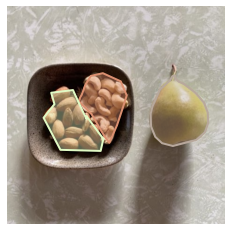

In [14]:
img_no = 7

annIds = train_coco.getAnnIds(imgIds=train_annotations_data['images'][img_no]['id'])
anns = train_coco.loadAnns(annIds)

# load and render the image
plt.imshow(plt.imread(os.path.join(TRAIN_IMAGE_DIRECTIORY,
                                   train_annotations_data['images'][img_no]['file_name'])))
plt.axis('off')
# Render annotations on top of the image
train_coco.showAnns(anns)

In [15]:
# img_info.head(50)

(512, 769, 3)
[22.5, 64.5, 406.0, 671.0]
[53.17625000000001, 547.2075207519531, 667.0562707519532, 192.2500000000001]


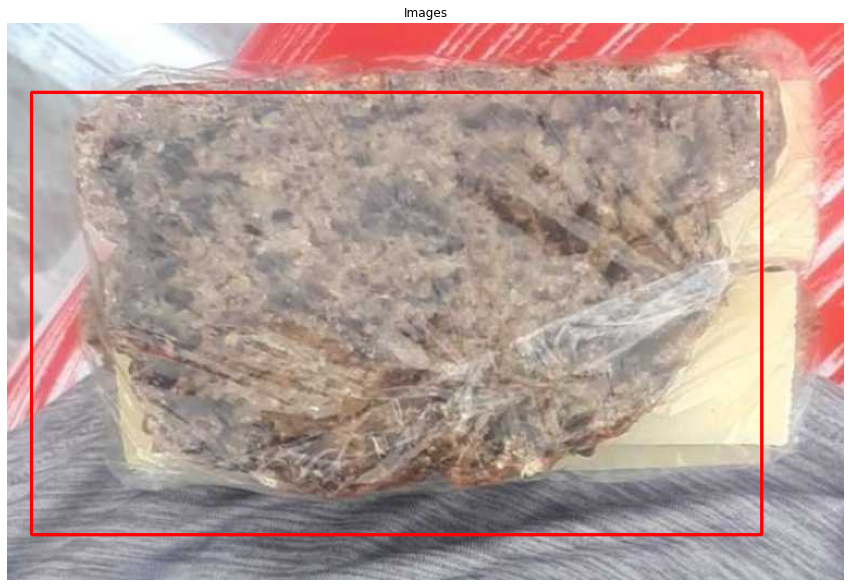

In [16]:
# w, h = 15, 15 # Setting width and height of every image
# rows, cols = 5, 5 # Setting the number of image rows & cols

fig = plt.figure(figsize=(15, 15)) # Making the figure with size 

plt.title("Images") 
plt.axis('off')

# Going thought every cell in rows and cols
# for i in range(1, cols * rows+1):
annIds = train_coco.getAnnIds(imgIds=93054)
anns = train_coco.loadAnns(annIds)

# fig.add_subplot(rows, cols, i)

# Show the image
# print(anns)

img = plt.imread(os.path.join(TRAIN_IMAGE_DIRECTIORY,'093054.jpg'))
print(img.shape)
for i in anns:
    [x,y,w,h] = i['bbox']
    print(i['bbox'])
    img = cv2.rectangle(img, (int(x), int(y)), (int(x+h), int(y+w)), (255,0,0), 2)
plt.imshow(img)

# # Render annotations on top of the image
# train_coco.showAnns(anns)

# # Setting the axis off
# plt.axis("off")

# # Showing the figure
# plt.show()

In [17]:
annIds

[134831, 135874]

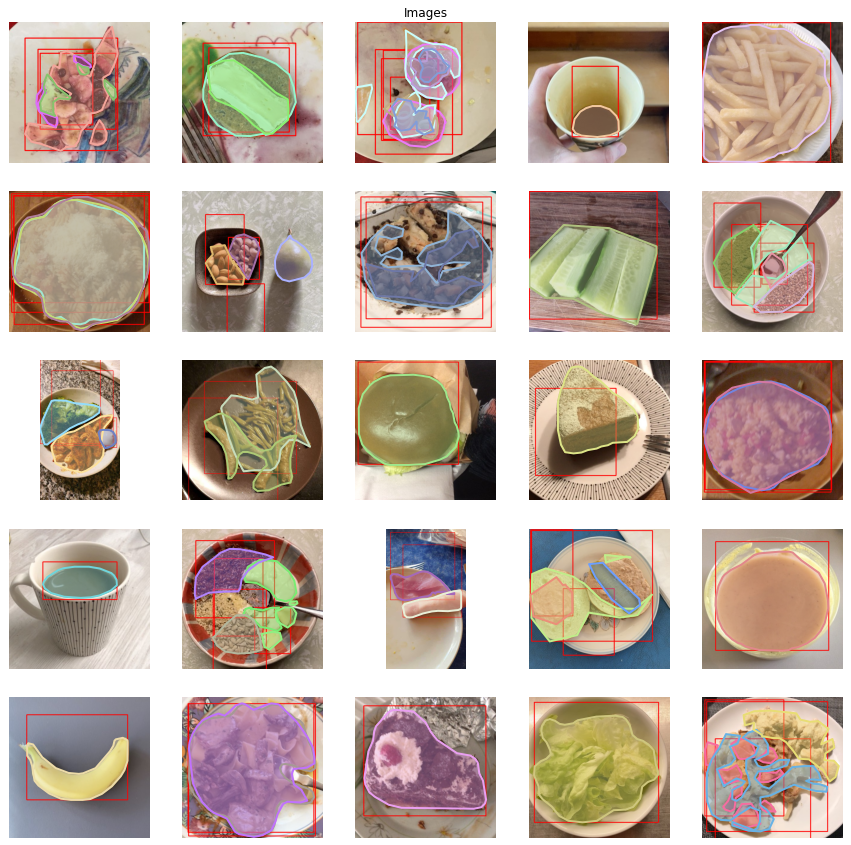

In [18]:
w, h = 15, 15 # Setting width and height of every image
rows, cols = 5, 5 # Setting the number of image rows & cols

fig = plt.figure(figsize=(15, 15)) # Making the figure with size 

plt.title("Images") 
plt.axis('off')

# Going thought every cell in rows and cols
for i in range(1, cols * rows+1):
    annIds = train_coco.getAnnIds(imgIds=img_info['id'][i])
    anns = train_coco.loadAnns(annIds)
    # print(img_info['id'][i])

    fig.add_subplot(rows, cols, i)

    # Show the image

    img = plt.imread(os.path.join(TRAIN_IMAGE_DIRECTIORY,img_info['file_name'][i]))
    for i in anns:
        [x,y,w,h] = i['bbox']
        cv2.rectangle(img, (int(x), int(y)), (int(x+h), int(y+w)), (255,0,0), 2)
    plt.imshow(img)

  # Render annotations on top of the image
    train_coco.showAnns(anns)

  # Setting the axis off
    plt.axis("off")

# Showing the figure
plt.show()

# Creating our Dataset 🔨

In this section we are goind to fix out dataset first ( because there is some issues with dataset ( size mismatch ) & creating our dataset to put into the model

## Fixing the Data

In [19]:
np.array(train_annotations_data['annotations'][n]['segmentation']).shape , np.array(train_annotations_data['annotations'][n]['bbox']).shape

((1, 38), (4,))

In [20]:
file_error = open('../resource/error_case.txt')
list_error = []
for item in file_error.readlines():
    list_error.append(int(item.replace('\n','')))
list_error

[134087, 153208, 24226, 169208, 93054, 119451, 127519]

In [21]:
train_annotations_data['images'][0]

{'id': 131094, 'file_name': '131094.jpg', 'width': 480, 'height': 480}

In [22]:
# train_annotations_data['annotations'][2]

In [23]:
len(train_annotations_data['images']), len(train_annotations_data['annotations'])

(39962, 76491)

In [24]:
def check_available_images(annotations, list_error):
    for err_case in list_error:
        for img in tqdm(annotations['images']):
            _id = img['id']
            if err_case == _id:
                print(f'remove image: {err_case}')
                annotations['images'].remove(img)
                if img not in annotations['images']:
                    print('remove done')
        for ann in tqdm(annotations['annotations']):
            _id = ann['image_id']
            if err_case == _id:
                print(f'remove annotation: {err_case}')
                annotations['annotations'].remove(ann)
                if ann not in annotations['annotations']:
                    print('remove done')
    return annotations

In [25]:
train_annotations_data = check_available_images(train_annotations_data, list_error)

100%|███████████████████████████████████████████████████▉| 39961/39962 [00:00<00:00, 834753.98it/s]


remove image: 134087
remove done


100%|███████████████████████████████████████████████████▉| 76490/76491 [00:00<00:00, 514733.07it/s]


remove annotation: 134087
remove done


  0%|                                                                    | 0/39961 [00:00<?, ?it/s]

remove image: 153208
remove done


100%|███████████████████████████████████████████████████▉| 76488/76490 [00:00<00:00, 716740.86it/s]


remove annotation: 153208
remove done
remove annotation: 153208
remove done


100%|██████████████████████████████████████████████████▉| 39959/39960 [00:00<00:00, 1430939.28it/s]


remove image: 24226
remove done


  0%|                                                                    | 0/76488 [00:00<?, ?it/s]

remove annotation: 24226
remove done
remove annotation: 24226
remove done
remove annotation: 24226


100%|███████████████████████████████████████████████████▉| 76484/76488 [00:00<00:00, 459217.79it/s]


remove done
remove annotation: 24226
remove done


100%|██████████████████████████████████████████████████▉| 39958/39959 [00:00<00:00, 1112966.09it/s]


remove image: 169208
remove done


  0%|                                                                    | 0/76484 [00:00<?, ?it/s]

remove annotation: 169208
remove done
remove annotation: 169208
remove done


100%|██████████████████████████████████████████████████▉| 39957/39958 [00:00<00:00, 1151580.44it/s]


remove image: 93054
remove done


  0%|                                                                    | 0/76482 [00:00<?, ?it/s]

remove annotation: 93054


100%|███████████████████████████████████████████████████▉| 76481/76482 [00:00<00:00, 798816.07it/s]


remove done


100%|███████████████████████████████████████████████████▉| 39956/39957 [00:00<00:00, 931694.47it/s]

remove image: 119451
remove done



 96%|█████████████████████████████████████████████████▉  | 73511/76481 [00:00<00:00, 640946.85it/s]

remove annotation: 119451
remove done
remove annotation: 119451
remove done
remove annotation: 119451
remove done
remove annotation: 119451
remove done


100%|██████████████████████████████████████████████████▉| 39955/39956 [00:00<00:00, 1292294.18it/s]


remove image: 127519
remove done


  0%|                                                                    | 0/76477 [00:00<?, ?it/s]

remove annotation: 127519


 99%|███████████████████████████████████████████████████▍| 75684/76477 [00:00<00:00, 702654.43it/s]

remove done
remove annotation: 127519
remove done


100%|███████████████████████████████████████████████████▉| 76475/76477 [00:00<00:00, 518101.77it/s]


In [27]:
# break

In [28]:
len(train_annotations_data['images']), len(train_annotations_data['annotations'])

(39955, 76475)

In [29]:
# Function for taking a annotation & directiory of images and returning new annoation json with fixed image size info
def fix_data(annotations, directiory):
    for n, i in enumerate(tqdm((annotations['images']))):
   
        img = cv2.imread(os.path.join(directiory,i["file_name"]))
 
        if img.shape[0] != i['height']:
            annotations['images'][n]['height'] = img.shape[0]
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

        if img.shape[1] != i['width']:
            annotations['images'][n]['width'] = img.shape[1]
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

    return annotations

train_annotations_data = fix_data(train_annotations_data, TRAIN_IMAGE_DIRECTIORY)

with open('../resource/train/ann_train_without_error.json', 'w') as f:
    json.dump(train_annotations_data, f)

  4%|██▌                                                      | 1767/39955 [00:39<13:02, 48.83it/s]

008618.jpg
{'id': 8618, 'file_name': '008618.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008618.jpg
{'id': 8618, 'file_name': '008618.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008619.jpg
{'id': 8619, 'file_name': '008619.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008619.jpg
{'id': 8619, 'file_name': '008619.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  4%|██▌                                                      | 1772/39955 [00:40<38:59, 16.32it/s]

008620.jpg
{'id': 8620, 'file_name': '008620.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008620.jpg
{'id': 8620, 'file_name': '008620.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  4%|██▌                                                      | 1776/39955 [00:41<45:02, 14.13it/s]

008621.jpg
{'id': 8621, 'file_name': '008621.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008621.jpg
{'id': 8621, 'file_name': '008621.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)
008626.jpg
{'id': 8626, 'file_name': '008626.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008626.jpg
{'id': 8626, 'file_name': '008626.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  4%|██▍                                                    | 1779/39955 [00:42<1:17:28,  8.21it/s]

008627.jpg
{'id': 8627, 'file_name': '008627.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008627.jpg
{'id': 8627, 'file_name': '008627.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  4%|██▍                                                    | 1785/39955 [00:42<1:16:19,  8.33it/s]

008628.jpg
{'id': 8628, 'file_name': '008628.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008628.jpg
{'id': 8628, 'file_name': '008628.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  5%|██▋                                                      | 1910/39955 [00:46<20:15, 31.31it/s]

008817.jpg
{'id': 8817, 'file_name': '008817.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008817.jpg
{'id': 8817, 'file_name': '008817.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  5%|██▊                                                      | 1931/39955 [00:47<26:33, 23.86it/s]

008864.jpg
{'id': 8864, 'file_name': '008864.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008864.jpg
{'id': 8864, 'file_name': '008864.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  5%|██▊                                                      | 1941/39955 [00:48<27:05, 23.39it/s]

008869.jpg
{'id': 8869, 'file_name': '008869.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008869.jpg
{'id': 8869, 'file_name': '008869.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  5%|██▊                                                      | 1964/39955 [00:49<31:00, 20.42it/s]

008919.jpg
{'id': 8919, 'file_name': '008919.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008919.jpg
{'id': 8919, 'file_name': '008919.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  5%|██▊                                                      | 1974/39955 [00:49<28:45, 22.01it/s]

008934.jpg
{'id': 8934, 'file_name': '008934.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
008934.jpg
{'id': 8934, 'file_name': '008934.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  9%|████▉                                                    | 3449/39955 [01:19<17:07, 35.52it/s]

011967.jpg
{'id': 11967, 'file_name': '011967.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
011967.jpg
{'id': 11967, 'file_name': '011967.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


  9%|████▉                                                    | 3490/39955 [01:20<18:01, 33.71it/s]

012045.jpg
{'id': 12045, 'file_name': '012045.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
012045.jpg
{'id': 12045, 'file_name': '012045.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


 11%|██████▏                                                  | 4302/39955 [01:37<16:36, 35.79it/s]

013989.jpg
{'id': 13989, 'file_name': '013989.jpg', 'width': 4032, 'height': 4032} (4032, 3024, 3)
013989.jpg
{'id': 13989, 'file_name': '013989.jpg', 'width': 3024, 'height': 4032} (4032, 3024, 3)


 14%|████████▎                                                | 5792/39955 [02:10<15:23, 36.98it/s]

017312.jpg
{'id': 17312, 'file_name': '017312.jpg', 'width': 3264, 'height': 3264} (3264, 2448, 3)
017312.jpg
{'id': 17312, 'file_name': '017312.jpg', 'width': 2448, 'height': 3264} (3264, 2448, 3)


 20%|███████████▏                                             | 7855/39955 [02:53<13:09, 40.64it/s]

021923.jpg
{'id': 21923, 'file_name': '021923.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
021923.jpg
{'id': 21923, 'file_name': '021923.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)


 21%|███████████▉                                             | 8381/39955 [03:04<11:20, 46.39it/s]

023295.jpg
{'id': 23295, 'file_name': '023295.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
023295.jpg
{'id': 23295, 'file_name': '023295.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)


 21%|███████████▉                                             | 8392/39955 [03:04<18:41, 28.14it/s]

023296.jpg
{'id': 23296, 'file_name': '023296.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
023296.jpg
{'id': 23296, 'file_name': '023296.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)


 22%|████████████▍                                            | 8676/39955 [03:10<14:21, 36.29it/s]

023975.jpg
{'id': 23975, 'file_name': '023975.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
023975.jpg
{'id': 23975, 'file_name': '023975.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)


 22%|████████████▍                                            | 8687/39955 [03:11<15:55, 32.73it/s]

023976.jpg
{'id': 23976, 'file_name': '023976.jpg', 'width': 4128, 'height': 4128} (4128, 2322, 3)
023976.jpg
{'id': 23976, 'file_name': '023976.jpg', 'width': 2322, 'height': 4128} (4128, 2322, 3)


 50%|████████████████████████████▏                           | 20085/39955 [07:11<14:39, 22.60it/s]

049396.jpg
{'id': 49396, 'file_name': '049396.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
049396.jpg
{'id': 49396, 'file_name': '049396.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)


 51%|████████████████████████████▋                           | 20494/39955 [07:21<09:49, 33.04it/s]

050167.jpg
{'id': 50167, 'file_name': '050167.jpg', 'width': 4032, 'height': 4032} (4032, 1960, 3)
050167.jpg
{'id': 50167, 'file_name': '050167.jpg', 'width': 1960, 'height': 4032} (4032, 1960, 3)


 55%|███████████████████████████████                         | 22153/39955 [08:01<13:37, 21.79it/s]

053873.jpg
{'id': 53873, 'file_name': '053873.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
053873.jpg
{'id': 53873, 'file_name': '053873.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)


 55%|███████████████████████████████                         | 22156/39955 [08:01<19:37, 15.12it/s]

053875.jpg
{'id': 53875, 'file_name': '053875.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
053875.jpg
{'id': 53875, 'file_name': '053875.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)


 55%|███████████████████████████████                         | 22161/39955 [08:02<24:44, 11.98it/s]

053879.jpg
{'id': 53879, 'file_name': '053879.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
053879.jpg
{'id': 53879, 'file_name': '053879.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)


 57%|███████████████████████████████▋                        | 22604/39955 [08:13<08:32, 33.87it/s]

056091.jpg
{'id': 56091, 'file_name': '056091.jpg', 'width': 4608, 'height': 4608} (4608, 3456, 3)
056091.jpg
{'id': 56091, 'file_name': '056091.jpg', 'width': 3456, 'height': 4608} (4608, 3456, 3)


100%|████████████████████████████████████████████████████████| 39955/39955 [14:43<00:00, 45.24it/s]


In [ ]:
def fix_data_val(annotations, directiory):
    for n, i in enumerate(tqdm((annotations['images']))):
        img = cv2.imread(os.path.join(directiory,i["file_name"]))
        if img.shape[0] != i['height']:
            print(n)
            annotations['images'][n]['height'] = img.shape[0]
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

        if img.shape[1] != i['width']:
            annotations['images'][n]['width'] = img.shape[1]
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

    return annotations

val_annotations_data = fix_data_val(val_annotations_data, VAL_IMAGE_DIRECTIORY)

with open('../resource/val/new_ann.json', 'w') as f:
    json.dump(val_annotations_data, f)

In [ ]:
dict_addres = val_annotations_data['images'][748]
plt.imread(os.path.join(VAL_IMAGE_DIRECTIORY,dict_addres['file_name'])).shape[:2], (dict_addres['height'], dict_addres['width'])